In [258]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm import tqdm

In [2]:
conversions = {
    "length (m)": 1.9732705e-7,
    "mass (kg)": 1.7826627e-36,
    "time (s)": 6.5821220e-16,
    "charge (C)": 1.8755468e-18,
    "electric field (V/m)": 4.3290844e-5,
    "magnetic induction (T)": 1.4440271e-3
}
conversions["velocity (m/s)"] = conversions["length (m)"]/conversions["time (s)"]
conversions["energy (J)"] = conversions["length (m)"]/conversions["time (s)"]

In [87]:
num_points = 10000
e = 8.5424546e-2 # = 1.60217733e-19 C
c = 1 # = 2.99792458e8 m/s
m = 5.1099906e5 # m_e = 9.1093897e-31 kg
E = np.array([0, 0, 0]) # = 0 V/m
B = np.array([1, 0, 0])/conversions["magnetic induction (T)"] # = 1 Tesla
t_span = (0, 300e-6/conversions["time (s)"]) # = 300 us
p0 = np.array([100e6, 100e6, 100e6]) # = 100 MeV
r0 = np.array([0, 0, 0]) # = 0 m
rtol = 1e-5 # = 0.001%
p_atol = 1*m/num_points
r_atol = c*t_span[1]/num_points
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, num_points) # 10000 points inside t_span

In [88]:
def gamma(p):
    return math.sqrt(1 + np.linalg.norm(p)**2/(m**2 * c**2))
def lorentz(v):
    return e * (E + np.cross(v, B) / c)
def g0(v, l, gv):
    return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]
def fun(t, y):
    p, r = np.split(y, 2)
    gv = gamma(p)
    v = p / (m * gv)
    l = lorentz(v)
    g = g0(v, l, gv)
    dpdt = l - 2/3 * e**2 / c * g
    drdt = v
    return np.concatenate([dpdt, drdt])
def plot3D(ax, u, c, prefix, suffix):
    x, y, z = u
    sc = ax.scatter(x, y, z, c=c, cmap="hot", marker=".", s=1)
    plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label="t (s)")
    ax.set_xlabel(prefix + "x" + suffix)
    ax.set_ylabel(prefix + "y" + suffix)
    ax.set_zlabel(prefix + "z" + suffix)
    return ax
def run(fun, t, y, progress):
    progress.n = t*conversions["time (s)"]*1e3
    progress.update(0)
    return fun(t, y)
def linear_fit(x, y, x_label="x", y_label="y", units=""):
    fit, cov = np.polyfit(x, y, 1, cov=True)
    uncertainty = np.sqrt(np.diag(cov))
    f = np.poly1d(fit)
    print(f"{y_label} = {fit[0]:.3}±{uncertainty[0]:.3} {x_label} + {fit[1]:.3}±{uncertainty[1]:.3} {units}")
    return f

In [5]:
y0 = np.concatenate([p0, r0])
with tqdm(total=t_span[1]*conversions["time (s)"]*1e3, position=t_span[0]*conversions["time (s)"]*1e3, bar_format='{l_bar}{bar}| {n_fmt:.7}ms/{total_fmt:.7}ms [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]', unit="ms") as progress:
    sol = solve_ivp(lambda t, y: run(fun, t, y, progress), t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

100%|██████████████████████████████████████████████████████████████████████████| 0.3ms/0.3ms [19:51<00:00, 3970.81s/ms]


In [658]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3489650
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000016C7C96F610>
   status: 0
  success: True
        t: array([0.00000000e+00, 4.55825649e+07, 9.11651297e+07, ...,
       4.55688901e+11, 4.55734483e+11, 4.55780066e+11])
 t_events: None
        y: array([[ 1.00000000e+08,  9.99998686e+07,  9.99997372e+07, ...,
         9.96467682e+07,  9.96467622e+07,  9.96467562e+07],
       [ 1.00000000e+08, -8.52270179e+07,  6.90861503e+07, ...,
         3.64442682e+06,  2.28275081e+07,  1.20766559e+07],
       [ 1.00000000e+08, -1.12821414e+08,  1.23333454e+08, ...,
         2.29809881e+07,  4.49340753e+06, -1.98827143e+07],
       [ 0.00000000e+00,  2.63185532e+07,  5.26406057e+07, ...,
         3.94824765e+11,  3.94869153e+11,  3.94913541e+11],
       [ 0.00000000e+00,  3.59755980e+06, -3.94431553e+05, ...,
         1.30193905e+06,  1.61445540e+06,  2.026

In [659]:
t_sol = sol.t
y_sol = sol.y
p_sol, r_sol = np.split(y_sol, 2)

In [660]:
t = 6.5821220e-16 * t_sol # in s
p = p_sol * 5.3442883e-28 # in kg * m/s
v_sol = p_sol / (m * gamma(p_sol))
v = v_sol * 2.99792458e8 # in m/s
r = r_sol * 1.9732705e-7 # in m
r_corr_sol = r_sol - np.tile(np.mean(r_sol, axis=1), (r_sol.shape[1],1)).T
r_corr = r_corr_sol * 1.9732705e-7 # in m
v_corr_sol = v_sol - np.tile(np.mean(v_sol, axis=1), (v_sol.shape[1],1)).T
v_corr = v_corr_sol* 2.99792458e8 # in m/s
omega_sol = np.cross(r_corr_sol, v_corr_sol, axis=0)/np.linalg.norm(r_corr_sol[1:], axis=0)**2
omega = omega_sol * 1.5192669e15 # in rad/s
beta_perp = np.linalg.norm(v_corr_sol[1:], axis=0)/c
beta = np.linalg.norm(v_corr_sol, axis=0)/c
P_sol = 2*(e*omega_sol[0])**2/(3*c)*(beta_perp**2)/(1 - beta**2)
P = P_sol * 0.24341350e-3 # in W

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

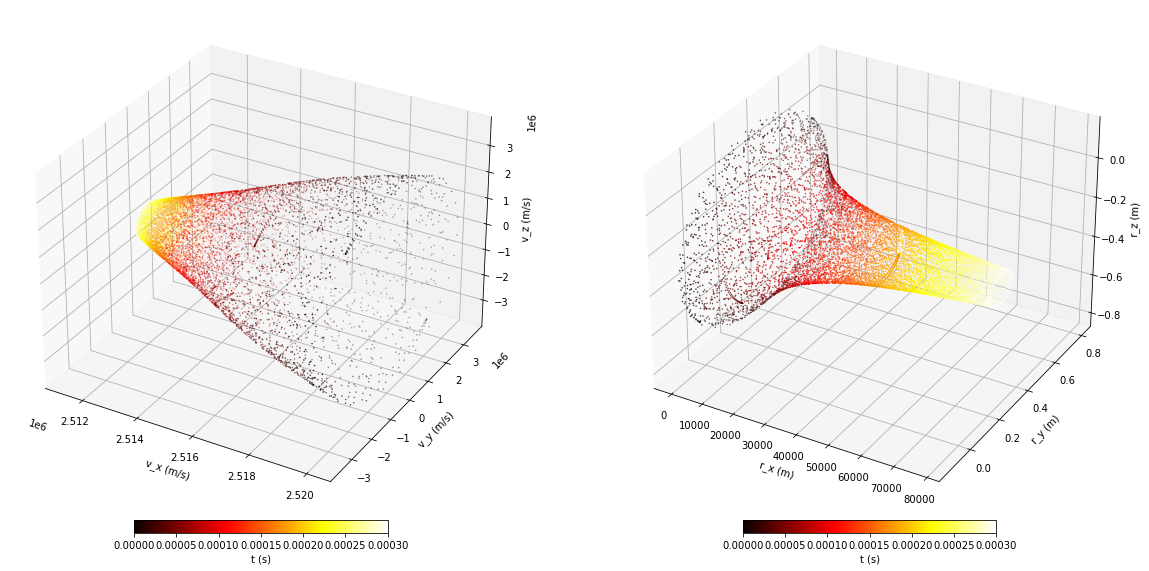

In [661]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw=dict(projection="3d"))
# axs[0].plot3D(*np.mean(v, axis=1),'ro') 
plot3D(axs[0], v, t, "v_", " (m/s)")
# axs[1].plot3D(*np.mean(r, axis=1),'ro') 
plot3D(axs[1], r, t, "r_", " (m)")

In [662]:
standard_figsize = (8, 6)
square_figsize = (7.5, 10)

Text(0.5, 0, 't (s)')

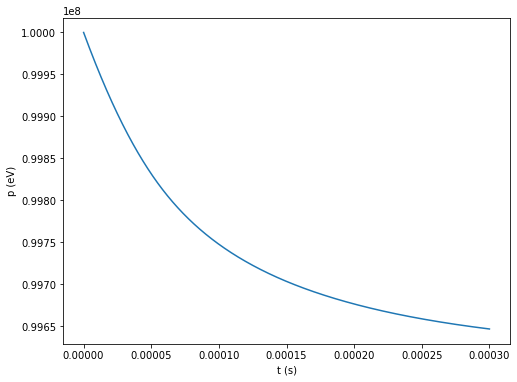

In [663]:
p_plot = np.linalg.norm(p_sol[:1], axis=0)
plt.figure(figsize=standard_figsize)
plt.plot(t, p_plot)
plt.ylabel("p (eV)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, p_plot, "t", "p", "eV")(t))

Text(0.5, 0, 't (s)')

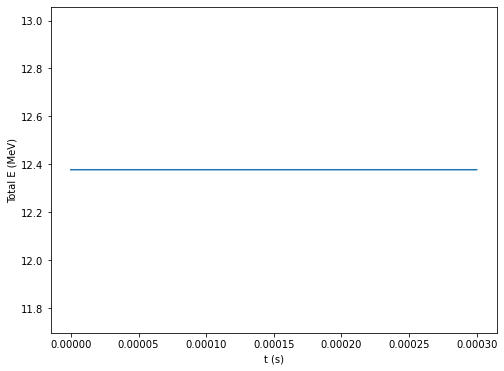

In [664]:
energy = np.sqrt(np.linalg.norm(p, axis=0)**2 * conversions["velocity (m/s)"]**2 + m*c**2*conversions["energy (J)"])
plt.figure(figsize=standard_figsize)
plt.plot(t, energy/1e6)
plt.ylabel("Total E (MeV)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, energy/1e6, "t", "E", "MeV")(t))

Text(0.5, 0, 't (s)')

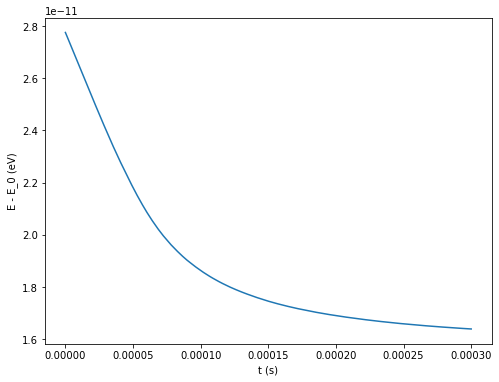

In [665]:
energy = np.sqrt(np.linalg.norm(p, axis=0)**2 * conversions["velocity (m/s)"]**2)
plt.figure(figsize=standard_figsize)
plt.plot(t, energy)
plt.ylabel("E - E_0 (eV)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, energy, "t", "E - E_0", "eV")(t))

Text(0.5, 0, 't (s)')

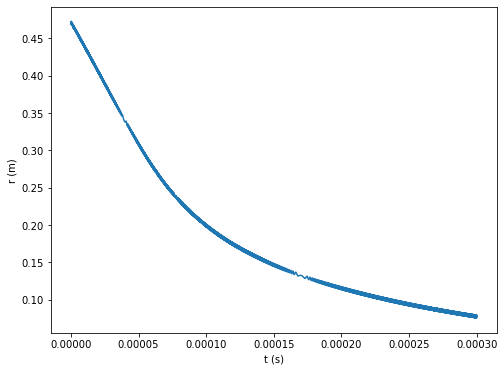

In [666]:
r_plot = np.linalg.norm(r_corr[1:], axis=0)
plt.figure(figsize=standard_figsize)
plt.plot(t, r_plot)
plt.ylabel("r (m)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, r_plot, "t", "r", "m")(t))

Text(0.5, 0, 't (s)')

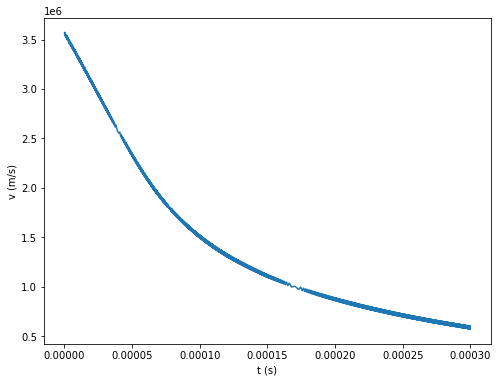

In [667]:
v_plot = np.linalg.norm(v_corr[1:], axis=0)
plt.figure(figsize=standard_figsize)
plt.plot(t, v_plot)
plt.ylabel("v (m/s)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, v_plot, "t", "v", "m/s")(t))

Text(0.5, 0, 't (s)')

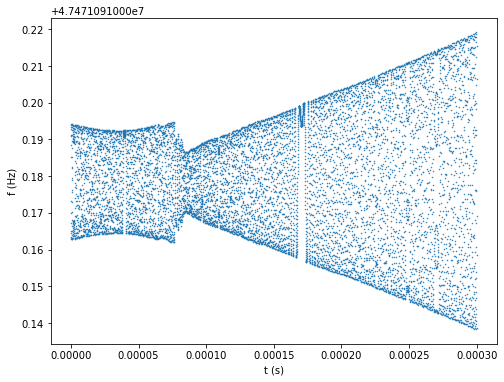

In [668]:
f = 2 * np.pi * np.abs(omega[0])
plt.figure(figsize=standard_figsize)
plt.scatter(t, f, marker=".", s=1)
plt.ylabel("f (Hz)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, f, "t", "f", "Hz")(t), c="orange")

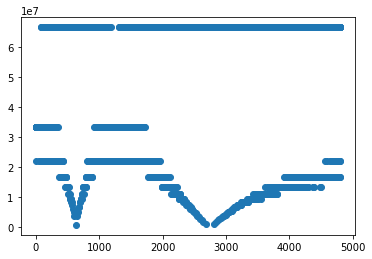

In [669]:
mask = r_corr[1] > 0.01
diff = np.concatenate([np.diff(t[mask]), [0]])
data = 2/np.diff(t[mask][diff > 1e-10000])
plt.scatter(np.arange(data.size), data)

Text(0.5, 0, 't (s)')

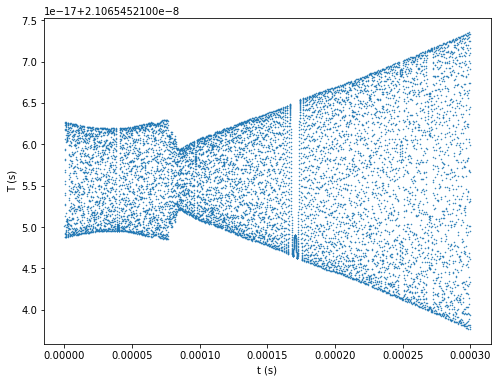

In [670]:
T = 1/f
plt.figure(figsize=standard_figsize)
plt.scatter(t, T, marker=".", s=1)
plt.ylabel("T (s)")
plt.xlabel("t (s)")
# plt.plot(t, linear_fit(t, T, "t", "T", "s")(t), c="orange")

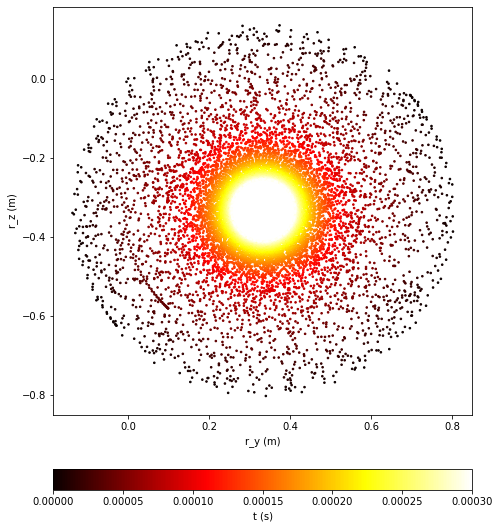

In [671]:
plt.figure(figsize=square_figsize)
plt.scatter(*r[1:], marker=".", c=t, cmap="hot", s=10)
# plt.plot(*np.mean(r[1:], axis=1), "ro")
plt.xlabel("r_y (m)")
plt.ylabel("r_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

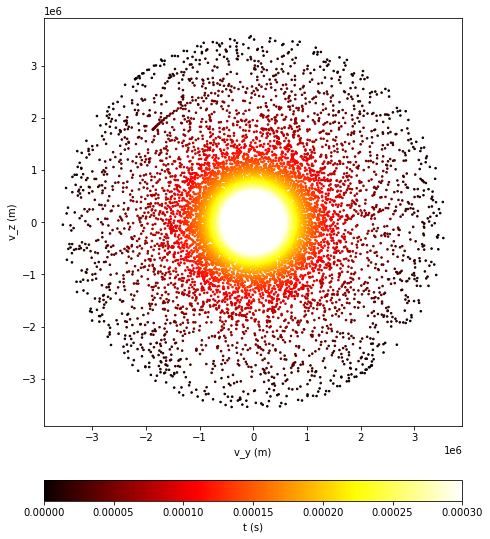

In [672]:
plt.figure(figsize=square_figsize)
plt.scatter(*v[1:], marker=".", c=t, cmap="hot", s=10)
# plt.plot(*np.mean(v[1:], axis=1), "ro")
plt.xlabel("v_y (m)")
plt.ylabel("v_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

Text(0.5, 0, 't (s)')

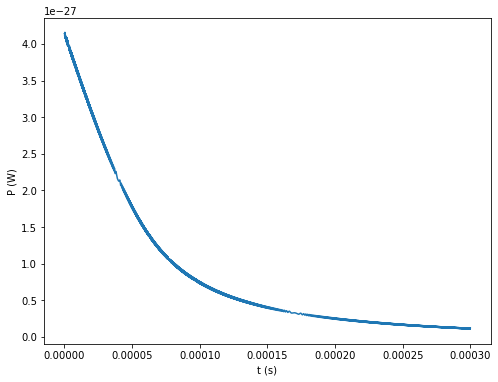

In [673]:
plt.figure(figsize=standard_figsize)
plt.plot(t, P)
plt.ylabel("P (W)")
plt.xlabel("t (s)")